<a href="https://colab.research.google.com/github/hoafng2511/fuzy_control/blob/main/BT4/9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📂 Chọn file diabetes.csv (từ điện thoại/máy tính)...


Saving diabetes.csv to diabetes (1).csv
✅ Đã đọc file: diabetes (1).csv  — shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



--- Training with seed = 7 ---
Seed 7 -> Best val acc=78.86% at threshold=0.465

--- Training with seed = 13 ---
Seed 13 -> Best val acc=81.30% at threshold=0.370

--- Training with seed = 21 ---
Seed 21 -> Best val acc=78.86% at threshold=0.430

--- Training with seed = 42 ---
Seed 42 -> Best val acc=81.30% at threshold=0.480

--- Training with seed = 77 ---
Seed 77 -> Best val acc=78.86% at threshold=0.625

>> Selected seed=13 with val_acc=81.30% and threshold=0.370
🎯 Test Accuracy: 72.73%
[[73 27]
 [15 39]]


              precision    recall  f1-score   support

           0     0.8295    0.7300    0.7766       100
           1     0.5909    0.7222    0.6500        54

    accuracy                         0.7273       154
   macro avg     0.7102    0.7261    0.7133       154
weighted avg     0.7459    0.7273    0.7322       154

💾 Model & meta đã lưu!


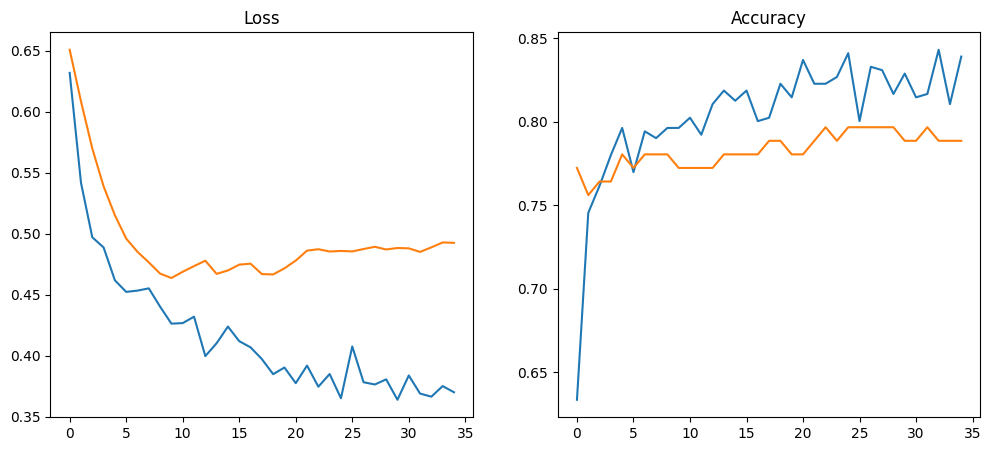

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6e48a4f7e249d6e570.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# =====================================================
# Full Colab: ANN duy nhất, có BloodPressure, upload từ điện thoại
# =====================================================
import io, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 1) Upload CSV
print("📂 Chọn file diabetes.csv (từ điện thoại/máy tính)...")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print("✅ Đã đọc file:", filename, " — shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

# 2) Xử lý dữ liệu
cols_zero_as_nan = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df2 = df.copy()
for c in cols_zero_as_nan:
    if c in df2.columns:
        df2[c] = df2[c].replace(0, np.nan)

X_df = df2.drop('Outcome', axis=1)
y = df2['Outcome'].values

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=42, stratify=y
)

medians = X_train_df.median(numeric_only=True)
X_train_df = X_train_df.fillna(medians)
X_test_df  = X_test_df.fillna(medians)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df.values)
X_test  = scaler.transform(X_test_df.values)
input_dim = X_train.shape[1]

# 3) Build ANN
def build_ann(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.4),

        layers.Dense(128, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(64, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),

        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=5e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 4) Train nhiều seed, chọn best
def set_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

seeds = [7, 13, 21, 42, 77]
best_record = {'val_acc': -1.0}

for seed in seeds:
    print(f"\n--- Training with seed = {seed} ---")
    set_seeds(seed)
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed
    )
    model = build_ann(input_dim)

    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-5, verbose=0)
    ]

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=400,
        batch_size=16,
        callbacks=callbacks,
        verbose=0
    )

    # threshold tối ưu
    val_probs = model.predict(X_val, verbose=0).ravel()
    thresholds = np.linspace(0.30, 0.70, 81)
    val_accs = [accuracy_score(y_val, (val_probs>=t).astype(int)) for t in thresholds]
    idx = int(np.argmax(val_accs))
    best_t_val = float(thresholds[idx])
    best_val_acc = float(val_accs[idx])

    print(f"Seed {seed} -> Best val acc={best_val_acc*100:.2f}% at threshold={best_t_val:.3f}")

    if best_val_acc > best_record['val_acc']:
        best_record.update({
            'val_acc': best_val_acc,
            'seed': seed,
            'threshold': best_t_val,
            'model': model,
            'history': history
        })

# 5) Evaluate best
best_model = best_record['model']
best_threshold = best_record['threshold']
print(f"\n>> Selected seed={best_record['seed']} with val_acc={best_record['val_acc']*100:.2f}% and threshold={best_threshold:.3f}")

test_probs = best_model.predict(X_test, verbose=0).ravel()
y_pred_test = (test_probs >= best_threshold).astype(int)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"🎯 Test Accuracy: {test_acc*100:.2f}%")
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test, digits=4))

# 6) Save model + meta
best_model.save('final_ann_only.h5')
np.savez('preprocess_meta.npz',
         medians=medians.values.astype(np.float64),
         columns=np.array(X_df.columns),
         mean_=scaler.mean_.astype(np.float64),
         scale_=scaler.scale_.astype(np.float64),
         threshold=np.array([best_threshold], dtype=np.float64))
print("💾 Model & meta đã lưu!")

# 7) Plot history
hist = best_record['history'].history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.plot(hist['loss']); plt.plot(hist['val_loss']); plt.title("Loss")
plt.subplot(1,2,2); plt.plot(hist['accuracy']); plt.plot(hist['val_accuracy']); plt.title("Accuracy")
plt.show()

# 8) Gradio interface
import gradio as gr

meta = np.load('preprocess_meta.npz', allow_pickle=True)
med_vals = meta['medians']
cols = list(meta['columns'])
scaler_mean = meta['mean_']
scaler_scale = meta['scale_']
threshold_saved = float(meta['threshold'][0])
loaded = keras.models.load_model('final_ann_only.h5')

def preprocess_input_row(row):
    arr = np.array(row, dtype=np.float64).reshape(1, -1)
    for j, col in enumerate(cols):
        if col in cols_zero_as_nan and arr[0, j] == 0.0:
            arr[0, j] = med_vals[j]
    arr = (arr - scaler_mean) / scaler_scale
    return arr

def predict_gradio(Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age):
    try:
        row = [
            float(Pregnancies), float(Glucose), float(BloodPressure),
            float(SkinThickness), float(Insulin), float(BMI),
            float(DiabetesPedigreeFunction), float(Age)
        ]
        xproc = preprocess_input_row(row)
        prob = loaded.predict(xproc, verbose=0)[0][0]
        label = "🔴 Có nguy cơ tiểu đường" if prob >= threshold_saved else "🟢 Không có nguy cơ"
        return label, float(prob), float(threshold_saved)
    except Exception as e:
        return f"❌ Error: {str(e)}", None, None

inputs = [
    gr.Number(label="Pregnancies"),
    gr.Number(label="Glucose"),
    gr.Number(label="BloodPressure"),
    gr.Number(label="SkinThickness"),
    gr.Number(label="Insulin"),
    gr.Number(label="BMI"),
    gr.Number(label="DiabetesPedigreeFunction"),
    gr.Number(label="Age")
]
outputs = [
    gr.Textbox(label="Result"),
    gr.Number(label="Probability"),
    gr.Number(label="Threshold used")
]

iface = gr.Interface(fn=predict_gradio, inputs=inputs, outputs=outputs,
                     title="ANN Diabetes Prediction",
                     description="Nhập 8 chỉ số -> ANN dự đoán nguy cơ tiểu đường. Model chỉ dùng ANN, đã train từ file CSV.")
iface.launch(share=True)
